In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import auc, plot_roc_curve,confusion_matrix, roc_curve,classification_report

In [76]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [77]:
df.shape

(768, 9)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


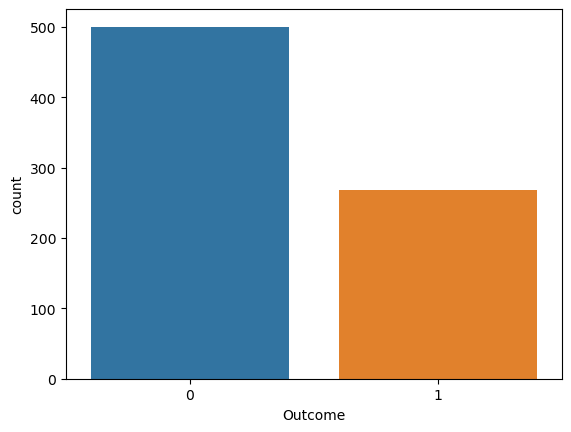

In [79]:
sns.countplot(x='Outcome', data = df)
plt.show()

Uneven distribution for classification 

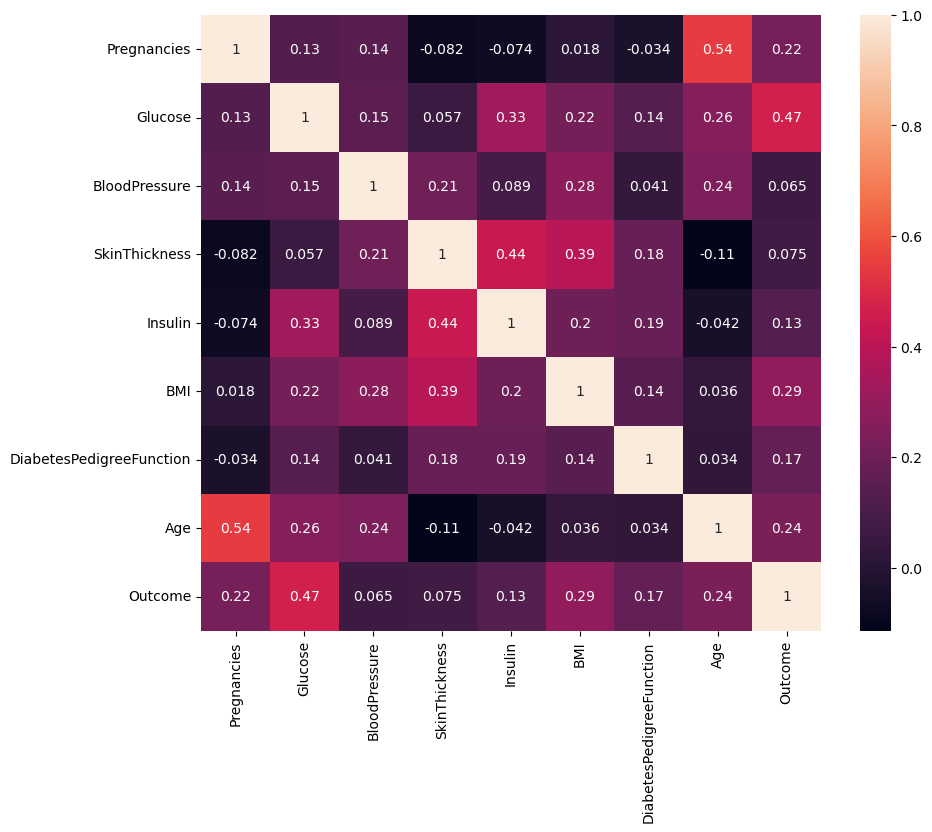

In [80]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot = True)
plt.show()

In [81]:
cols = df.columns
cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [82]:
(df==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [83]:
zeroes = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

df[zeroes] = df[zeroes].replace(0,np.nan)
df[zeroes] = KNNImputer(n_neighbors=5).fit_transform(df[zeroes])

(df[zeroes]==0).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [84]:
def plotbox(df):
    plt.figure(figsize=(15,12))
    for i, col in enumerate(cols,1):
        plt.subplot(3,3,i)
        sns.boxplot(x=col, data = df)
    plt.show()

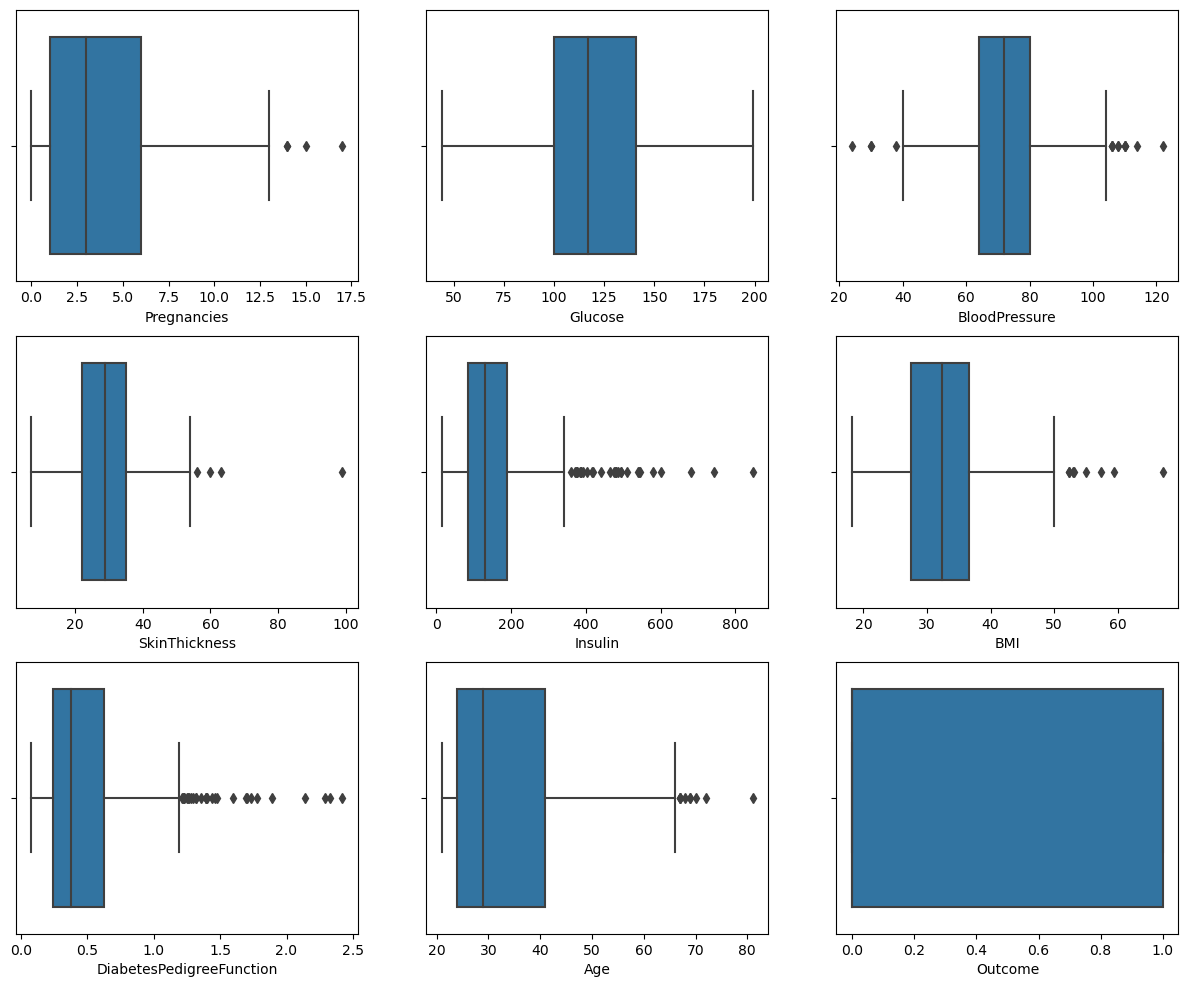

In [85]:
plotbox(df)

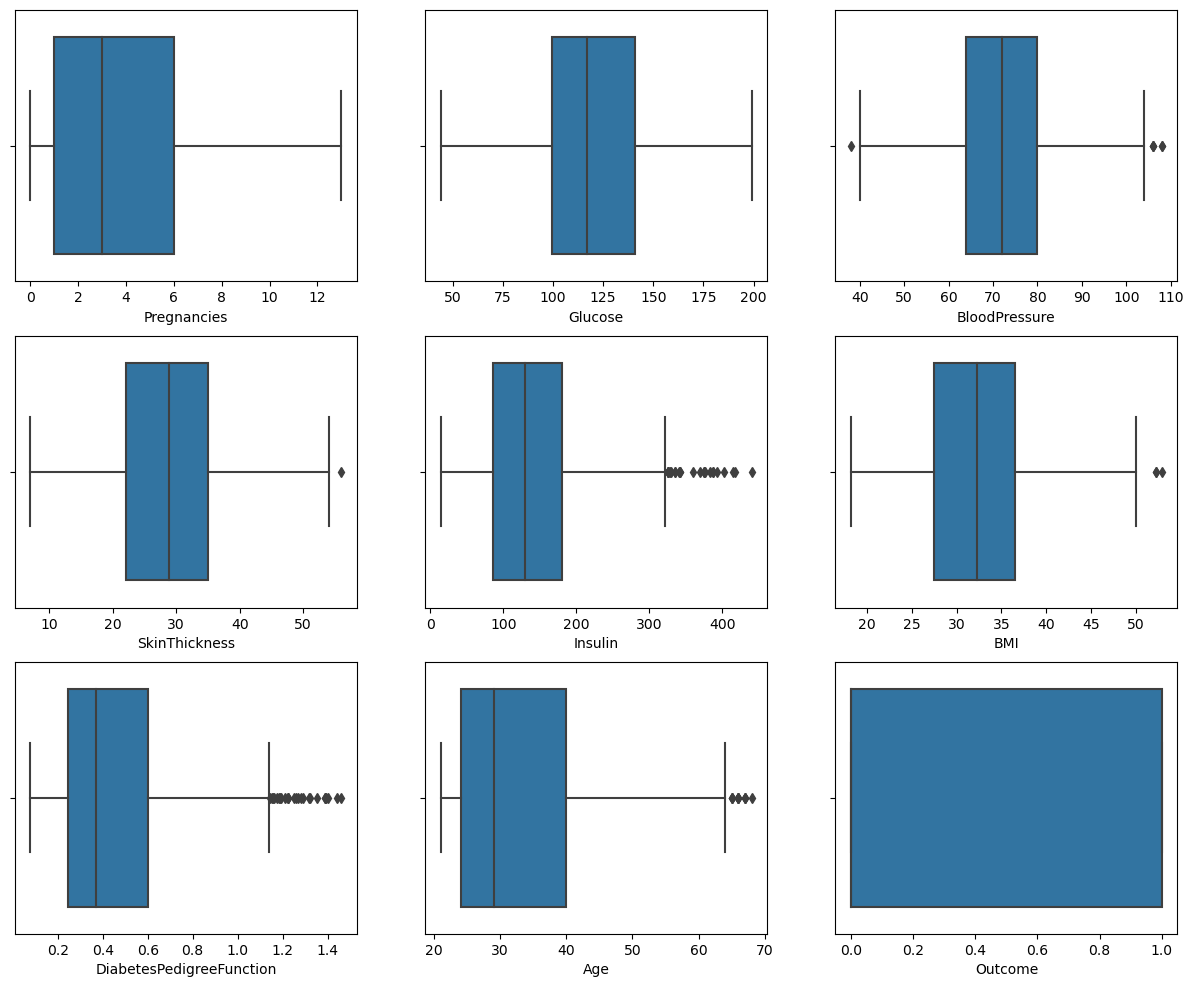

In [86]:
def remove_outlier(df, col):
    #thresh = 3
    z = zscore(df[col])
    outliers = abs(z)>3
    df.loc[outliers, col] = df[col].median()
    return df

cols = list(df.columns)
#cols.remove("Outcome")
for col in cols:
    df = remove_outlier(df, col)
plotbox(df)

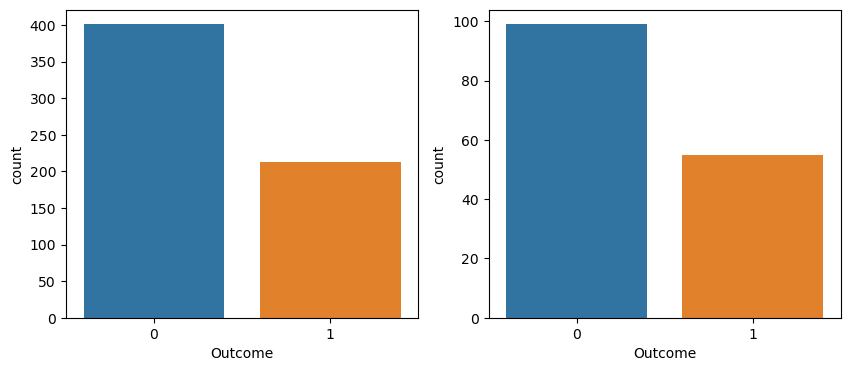

In [87]:
df_x = df.drop('Outcome',axis=1)
df_y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state = 42)

df_train = pd.concat([pd.DataFrame(X_train, columns = X_train.columns), pd.Series(y_train, name='Outcome')], axis = 1)
df_test = pd.concat([pd.DataFrame(X_test, columns = X_test.columns), pd.Series(y_test, name='Outcome')], axis = 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='Outcome', data = df_train)
plt.subplot(1,2,2)
sns.countplot(x='Outcome', data = df_test )
plt.show()

Lets keep the df_test completely for final eval metrics

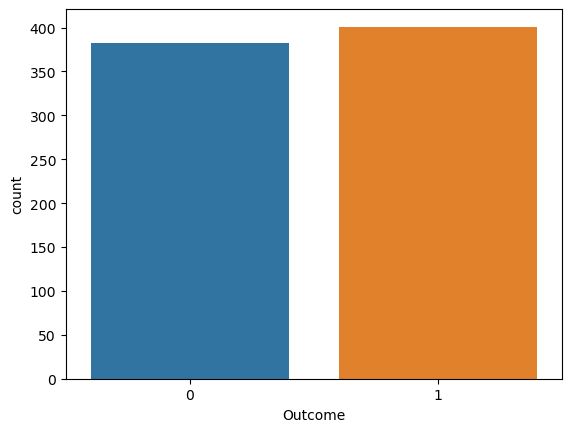

In [88]:
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
rdf_x, rdf_y = resample.fit_resample(X_train, y_train)

rdf = pd.concat([pd.DataFrame(rdf_x, columns = X_train.columns), pd.Series(rdf_y, name='Outcome')], axis = 1)
sns.countplot(x= 'Outcome', data = rdf)
plt.show()

In [121]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Scaled_X = sc.fit_transform(rdf_x)

In [90]:
Scaled_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.586659,-1.357783,-0.811331,-0.382684,-0.673109,0.342500,-0.565633,-1.180296
1,1.679058,-0.451365,0.817066,-0.616481,-0.502801,-0.753399,3.183208,1.536918
2,-0.910332,0.422682,-2.439728,-1.200974,-0.864379,-0.674896,0.775976,-1.086599
3,-1.234006,1.134868,-2.077862,-0.289166,2.976727,-1.742534,-0.757292,2.942374
4,0.708036,0.260821,0.636133,0.903199,2.895503,2.072702,-0.818623,1.162130


Trying LR, RFC, GNB, DTC, XGB

In [91]:
models = []
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('DT', DecisionTreeClassifier(random_state=42)))
models.append(('XG', XGBClassifier(random_state=42)))

In [92]:
#filler code
max_roc = 0
selectmodel = ''
for name, model in models: 
    train_X, test_X, train_y, test_y = train_test_split(Scaled_X, rdf_y, test_size=0.2, random_state=42)
    model.fit(train_X, train_y)
    pred_y = model.predict_proba(test_X)[:,1]
    roc = roc_auc_score(test_y, pred_y)
    acc = accuracy_score(test_y, model.predict(test_X))
    print(name,roc)
    if roc>max_roc:
        max_roc = roc
        selectmodel = name
        mean_acc = cross_val_score(model, Scaled_X, rdf_y, cv=5,scoring='accuracy').mean()
        cvs = cross_val_score(model, Scaled_X, rdf_y, cv=5,scoring='accuracy')
print('Best Model: ' + selectmodel, max_roc, mean_acc, cvs)
        

LR 0.8313859136643946
RF 0.8881045115222331
NB 0.8172671210645894
DT 0.8219733852645246
XG 0.8795845504706264
Best Model: RF 0.8881045115222331 0.8380287440796994 [0.84076433 0.8343949  0.79617834 0.86624204 0.8525641 ]


In [93]:
parameters_xg = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}
xg = XGBClassifier()

cv_xg = GridSearchCV(xg, param_grid=parameters_xg, cv=5, scoring='accuracy')
cv_xg.fit(Scaled_X,rdf_y)
print(cv_xg.best_estimator_)
print(cv_xg.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
0.8380532418748979


In [115]:
param_grid_rf = {
    'n_estimators':[100,125,150],
    'max_depth':[7,9,11,13]
}
rf = RandomForestClassifier()

cv_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')
cv_rf.fit(Scaled_X,rdf_y)
print(cv_rf.best_estimator_)
print(cv_rf.best_score_)

RandomForestClassifier(max_depth=13, n_estimators=150)
0.8341989220970113


In [97]:
best_model_xg = XGBClassifier(max_depth =5, learning_rate = 0.1, n_estimators = 300, gamma = 0, random_state=42)
best_model_xg.fit(Scaled_X, rdf_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [116]:
best_model_rf = RandomForestClassifier(max_depth=13,n_estimators=150)
best_model_rf.fit(Scaled_X, rdf_y)

RandomForestClassifier(max_depth=13, n_estimators=150)

In [122]:
X_test = df_test.drop('Outcome',axis=1)
y_test = df_test['Outcome']
scaled_test_x = sc.transform(X_test)
predictions_xg = best_model_xg.predict(scaled_test_x)
predictions_rf = best_model_rf.predict(scaled_test_x)
#accuracy = accuracy_score(y_test, predictions)
#confusion = confusion_matrix(y_test, predictions)
# report = classification_report(y_test, predictions)

In [123]:
accuracy_xg = accuracy_score(y_test, predictions_xg)
confusion_xg = confusion_matrix(y_test, predictions_xg)
# report = classification_report(y_test, predictions)

In [124]:
accuracy_rf = accuracy_score(y_test, predictions_rf)
confusion_rf = confusion_matrix(y_test, predictions_rf)

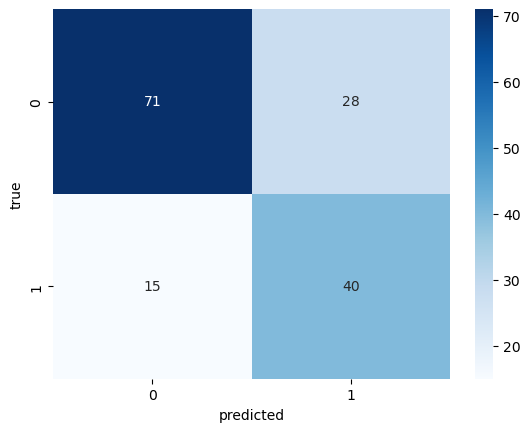

In [125]:
sns.heatmap(confusion_xg, annot=True, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

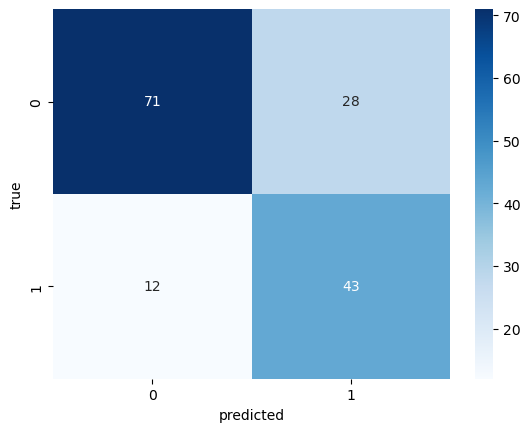

In [126]:
sns.heatmap(confusion_rf, annot=True, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

False Positives: 28
False Negatives: 12
True Negatives : 71
True Positives : 43